###### Load libraries and directories

In [1]:
from IPython.display import display, HTML

In [2]:
# from IPython import get_ipython
from tqdm.notebook import tqdm
import pickle
import os
import math as math
from scipy.signal import convolve2d
import pprint
pp = pprint.PrettyPrinter(indent=1)

# Custom modules for debugging
from SliceViewer import ImageSliceViewer3D, ImageSliceViewer3D_1view,ImageSliceViewer3D_2views
from investigate import *
import matplotlib.cm as cm
#pd.set_option("display.max_rows", 10)
      
import json
from run_sma_experiment import find_l3_images,output_images
import pprint
from L3_finder import *

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)

Using TensorFlow backend.


In [3]:
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [5]:
cwd = os.getcwd()
print(cwd)
data = '/tf/data'
pickles = '/tf/pickles'
models = '/tf/models'

/tf/smipipeline


In [6]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction_CV.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'l3_finder': {'cache_dir': '/tf/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/tf/data',
               'model_path_dir': '/tf/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/tf/output/l3/cv',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/tf/models/muscle/cv_final',
                      'output_directory': '/tf/output/ms/cv'}}


## Section 1 - Process final images

## Section 2 - Load each study into subject object
<br>
Subject object defined in L3finder.ingest

In [7]:
config['l3_finder']['new_tim_dicom_dir_structure']

True

In [8]:
# Debug
print("Finding subjects")

subjects = list(
    find_subjects(
        config['l3_finder']["dicom_dir"],
        new_tim_dir_structure=config['l3_finder']['new_tim_dicom_dir_structure']
    )
)

print('Subjects found: ', len(subjects))

Finding subjects
Subjects found:  2367


## Section-3 - check if there are subjects with multiple folders (studies)

In [ ]:
%%time
# Find series images
print("Finding series")
series = list(flatten(tqdm((s.find_series() for s in subjects),total=len(subjects))))

In [ ]:
print("Total number of series found: ", len(series))

In [ ]:
%%time
sagittal_series, axial_series, excluded_series = separate_series(series)

In [ ]:
print("Length of valid pats: ", len(subjects))
print("Length of sagittal series", len(sagittal_series))
print("Length of axial series", len(axial_series))
print("Length of excluded series", len(excluded_series))
print("Length of all series in dataset", len(series))

### Make sure each subject has at the max only 1 axial and 1 sagittal series

In [ ]:
ax_ids = [ax.subject.id_ for ax in axial_series]
sag_ids = [sag.subject.id_ for sag in sagittal_series]

def find_duplicates(id_list):
    uniques = []
    duplicates = []
    for ids in id_list:
        if ids in uniques:
            duplicates.append(ids)
        else:
            uniques.append(ids)
            
    return uniques,duplicates


ax_u,ax_d = find_duplicates(ax_ids)
sag_u,sag_d = find_duplicates(sag_ids)

print('Ax duplicates: ', ax_d)
print('Sag duplicates: ', sag_d)

In [ ]:
# Find the series objects to investigate
ax_d_series = [ax for ax in axial_series if ax.subject.id_ in ax_d]
sag_d_series = [ax for ax in sagittal_series if ax.subject.id_ in ax_d]

In [ ]:
df_dl= load_object(os.path.join(pickles,'df_final.pkl'))
display(df_dl[df_dl['ID']==ax_d[0]])

## Reconstruct Missing Sagittals

In [ ]:
# By default code filters 0.5mm slices, but I am letting them pass by setting it to 0
constructed_sagittals = construct_series_for_subjects_without_sagittals(
        subjects, sagittal_series, axial_series,thickness_filter=0) 

In [ ]:
print(
        "Series separated\n",
        len(sagittal_series), "sagittal series.",
        len(axial_series), "axial series.",
        len(excluded_series), "excluded series.",
        len(constructed_sagittals), "constructed series.",
    )

In [ ]:
sagittal_series.extend(constructed_sagittals)

In [ ]:
save_object(axial_series,os.path.join(pickles,'axial_curated.pkl'))
save_object(sagittal_series,os.path.join(pickles,'sagittal_curated.pkl'))

## Create MIPS

In [ ]:
print("Creating sagittal MIPS")
mips = create_sagittal_mips_from_series(
        many_series=sagittal_series,
        cache_dir=config['l3_finder'].get("cache_dir", None),
        cache=config['l3_finder'].get("cache_intermediate_results", False),
    )

In [ ]:
save_object(mips,os.path.join(pickles,'mips.pkl'))

## Find L3

In [ ]:
mips = load_object(os.path.join(pickles,'mips.pkl'))

In [ ]:
print("Preprocessing Images")
preprocessed_images = preprocess_images(mips)

# Sagittal mip is redundant, get rid just use preprocessed images
sagittal_mips = [SagittalMIP(i) for i in preprocessed_images]

print("Separate heights for better batching")
mips_by_dimension = group_mips_by_dimension(sagittal_mips)
print("Dimensions in set:", mips_by_dimension.keys())

In [ ]:
save_object(mips_by_dimension,os.path.join(pickles,'mips_by_dimension.pkl'))

## Find L3 - step 2

In [ ]:
mips_by_dimension = load_object(os.path.join(pickles,'mips_by_dimension.pkl'))
axial_series = load_object(os.path.join(pickles,'axial_curated.pkl'))
sagittal_series = load_object(os.path.join(pickles,'sagittal_curated.pkl'))

In [ ]:
# Get all models in model path dir
models_dir = config['l3_finder']['model_path_dir']

# Get all models in models dir
models_list = sorted([f for f in os.listdir(models_dir) if f.endswith('.h5')])
print(models_list)
folds = len(models_list)

for fold in range(folds):
    model_path = os.path.join(models_dir,models_list[fold])
    print(model_path)

In [ ]:
runname = 'CV'
if __name__ == "__main__":
    for fold in range(folds):
        model_path = os.path.join(models_dir,models_list[fold])
        print("Making predictions for fold ", fold, 'Path: ', model_path)
        prediction_results = []
        prediction_errors = []
        for dimension, sagittal_mips in mips_by_dimension.items():
            dim_group_results,errors = make_predictions_for_sagittal_mips(
                sagittal_mips,
                model_path=model_path,
                shape=dimension
            )
            prediction_results.extend(dim_group_results)
            prediction_errors.extend(errors)

        # Save prediction results
        pred_results_file = 'prediction_results_' + str(fold) + '_' +  runname + '.pkl'
        pred_errors_file = 'prediction_errors_' + str(fold) + '_' +  runname + '.pkl'
        save_object(prediction_results,os.path.join(pickles,pred_results_file))
        save_object(prediction_errors,os.path.join(pickles,pred_errors_file))

### Save l3 prediction results

In [ ]:
axial_series = load_object(os.path.join(pickles,'axial_curated.pkl'))

In [ ]:
len(axial_series)

In [ ]:
# Load prediction_results pickle files
runname = 'CV'

output_dir = config["l3_finder"]["output_directory"]
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

prediction_results_list = sorted([f for f in os.listdir(pickles) if (f.startswith('prediction_results_') and f.endswith(runname+'.pkl'))])
folds = len(prediction_results_list)
print(folds)

if __name__ == "__main__":
    for fold in range(folds):
        pred_file = os.path.join(pickles,prediction_results_list[fold])
        prediction_results = load_object(pred_file)
        print('Total predictions: ',len(prediction_results))
        print('Building L3 images for fold: ', fold)
        l3_images = build_l3_images(axial_series, prediction_results)
        print('Total images: ',len(l3_images))
        # Don't run this unless you have new L3 results
        print("Outputting L3 images for fold: ", fold)
        # Clears pixel data from memory aafter outputting
        output_dir = os.path.join(config["l3_finder"]["output_directory"],str(fold))
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        l3_images = output_images(
        l3_images,
        args=dict(
            output_directory=output_dir,
            should_plot=config["l3_finder"]["show_plots"],
            should_overwrite=config["l3_finder"]["overwrite"],
            should_save_plots=config["l3_finder"]["save_plots"]
        ))

## Find mean L3 prediction

In [7]:
import csv
import sys
from collections import defaultdict
from pathlib import Path

from L3_finder import L3Image
from l3finder import ingest

from compare_best_to_manual_l3_and_seg import MinimalPrediction, MinimalResult

In [8]:
def load_l3_predictions(l3_prediction_dir,nfolds):
    subject_id_col = 0
    pred_in_px_col = 1
    predictions = defaultdict(list)

    for fold_index in range(0, nfolds):
        csv_dir = os.path.join(l3_prediction_dir,str(fold_index))
        csv_path = Path(csv_dir,'l3_prediction_results.csv')
        with open(csv_path) as csvfile:
            reader = csv.reader(csvfile)
            next(reader)

            for row in reader:
                subid = row[subject_id_col].split('-')[0]
                predictions[subid].append(float(row[pred_in_px_col]))

    return predictions

def calc_mean_predictions(all_predictions: defaultdict):
    result = {}
    for subject_id, prediction_list in all_predictions.items():
        result[subject_id] = np.mean(prediction_list)
    return result

def find_subjects_w_preds(predictions, all_subjects):
    subject_ids_w_preds = set(predictions.keys())
    return [s for s in all_subjects if s.id_ in subject_ids_w_preds]



def load_l3_images_from_predictions(mean_predictions, subjects_w_preds,axials,sagittals):
    l3_images = []

    for subject in subjects_w_preds:
        sagittal_series = [s for s in sagittals if s.subject.id_ == subject.id_][0]
        axial_series = [a for a in axials if a.subject.id_ == subject.id_][0]
        l3_images.append(
            L3Image(
                axial_series=axial_series,
                sagittal_series=sagittal_series,
                prediction_result=MinimalResult(
                    MinimalPrediction(
                        predicted_y_in_px=mean_predictions[subject.id_]
                    )
                )
            )
        )
    return l3_images

In [9]:
axial_series = load_object(os.path.join(pickles,'axial_curated.pkl'))
sagittal_series = load_object(os.path.join(pickles,'sagittal_curated.pkl'))

In [10]:
runname = 'CV'
prediction_results_list = sorted([f for f in os.listdir(pickles) if (f.startswith('prediction_results_') and f.endswith(runname+'.pkl'))])
folds = len(prediction_results_list)
print(folds)

5


In [11]:
if __name__ == "__main__":
    all_predictions = load_l3_predictions(config["l3_finder"]["output_directory"],folds)
    mean_predictions = calc_mean_predictions(all_predictions)
    subjects_w_preds = find_subjects_w_preds(mean_predictions, list(ingest.find_subjects(config['l3_finder']["dicom_dir"])))
    l3_images = load_l3_images_from_predictions(mean_predictions, subjects_w_preds, axial_series, sagittal_series)

In [12]:
print(len(l3_images))

2367


## Fix Poor Table Removal ISSUE

In [13]:
# Investigate L3 images
import SimpleITK as sitk
from run_sma_experiment import rescale_1024, remove_table, _remove_table, threshold_images, normalize_images
def zero_ims(rescaled_images):
    zeroed_images = [
        rs_im + (rs_im.min() * -1)
        for rs_im
        in rescaled_images
    ]
    return zeroed_images

def rescale_1024(img):
    if np.min(img) == 0 or np.min(img)==1: # Rescale intercept -1024, slope 1 or 0
        # Rescale to -1024
        img = img.astype('int16')
        img = img - 1024 # undo rescale [proper HU]
        img[img <= -1020] = -2048  # scale back to match others
        return img
    elif np.min(img) == -1024:
        img = img.astype('int16')
        img[img <= -1020] = -2048  # scale back to match others
        return img
    elif np.min(img) == -2000:
        if np.mean(img) <= -500: # Images with rescaleintercept = -1024
            img = img.astype('int16')
            img[img <= -1020] = -2048  # scale back to match others
            return img
        else:       # Images with rescaleintercept = 0
            img = img.astype('int16')
            img = img - 1024 # undo rescale [proper HU]
            img[img <= -1020] = -2048  # scale back to match others
            return img
    elif np.min(img) < -2048: # MIP images
        img = img.astype('int16')
        img[img <= -1020] = -2048  # scale back to match others
        return img
    else:
        return img

def estimate_noise(I):
    H, W = I.shape

    M = [[1, -2, 1],
           [-2, 4, -2],
           [1, -2, 1]]

    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

    return sigma    

def smooth_img(input): 
    CT = sitk.GetImageFromArray(input)
    rgsmootherfilter = sitk.SmoothingRecursiveGaussianImageFilter()
    rgsmootherfilter.SetSigma(2.0)
    rgsmootherfilter.SetNormalizeAcrossScale(True)
    rgsmoothedimage  = rgsmootherfilter.Execute(CT)
    ctnoise =estimate_noise(input)
    output = sitk.GetArrayFromImage(rgsmoothedimage)
    smnoise = estimate_noise(output)
    #print('Before noise: ',ctnoise, ' After noise: ', smnoise)
    return output


def _remove_table_mod(CT_nda,l_thresh=1300,h_thresh=3500,seed=[256, 256]):
    CT = sitk.GetImageFromArray(CT_nda)
    #
    # Blur using CurvatureFlowImageFilter
    #
    blurFilter = sitk.CurvatureFlowImageFilter()
    blurFilter.SetNumberOfIterations(5)
    blurFilter.SetTimeStep(0.125)
    image = blurFilter.Execute(CT)
               
    #
    # Set up ConnectedThresholdImageFilter for segmentation
    #
    segmentationFilter = sitk.ConnectedThresholdImageFilter()
    segmentationFilter.SetLower(float(l_thresh))
    segmentationFilter.SetUpper(float(h_thresh))
    segmentationFilter.SetReplaceValue(1)
    segmentationFilter.AddSeed(seed)
    
    
    

    # Run the segmentation filter
    image = segmentationFilter.Execute(image)
    image[seed] = 1

    # Fill holes
    image = sitk.BinaryFillhole(image);

    # Masking FIlter
    maskingFilter = sitk.MaskImageFilter()
    CT_noTable = maskingFilter.Execute(CT,image)
    CT_noTable = sitk.GetArrayFromImage(CT_noTable)
    

    # CHeck if the mean HU value is too low, which means CT did not have table and removed body pixels,
    # Happens for very young patients with small field of view
    if np.mean(CT_noTable) < 100: # if mean HU of final image is too low, return input CT
        return CT_nda
    else:
        return CT_noTable
    


In [14]:
test_subs0 = ['Z876503','Z486791', 'Z913811', 'Z456574', 'Z489517', 'Z1295431', 'Z1056292',
 'Z1888427', 'Z370830' ,'Z1196674' ,'Z1033402', 'Z1212421', 'Z797075',
 'Z1224134' ,'Z857466', 'Z1239638' ,'Z563801', 'Z1198129', 'Z883781', 'Z1085469',
 'Z867082' ,'Z298760' ,'Z921388' ,'Z1976743' ,'Z574459', 'Z1944470' ,'Z1332420',
 'Z15992' ,'Z1140026' ,'Z1119985', 'Z1182130', 'Z467063' ,'Z1274627', 'Z1266012',
 'Z1279217', 'Z505334' ,'Z846542', 'Z1037763', 'Z1263347', 'Z862381', 'Z857086',
 'Z469954' ,'Z1197230', 'Z472264', 'Z1830146', 'Z827107' ,'Z542033' ,'Z538768',
 'Z842237' ,'Z568227', 'Z832424', 'Z1683576']


test_subs_lf = ["Z489517", "Z456574", "Z1056292", "Z1888427", "Z1295431", "Z1212421", "Z1332420", "Z1317515",
             "Z1976743", "Z1951972", "Z1085469", "Z1263347", "Z1037763", "Z1197230", "Z1830146", "Z542033",
             "Z631817", "Z832424", "Z723781", "Z1238640", "Z1182222", "Z1095320", "Z1262816", "Z1709049",
             "Z1222041", "Z1365961", "Z1269771", "Z1232902", "Z458309", "Z1120349", "Z1130154", "Z1280191",
             "Z486791", "Z1418766", "Z508456", "Z634845", "Z1183847", "Z996722", "Z708250", "Z913811", "Z1046920",
             "Z702930", "Z1166481", "Z1421847", "Z1804059", "Z651186", "Z1388086", "Z546239", "Z617704", "Z1261562",
             "Z1084555"]

test_subs_lm = ["Z1996094", "Z1262030", "Z705523", "Z1762020", "Z1286046", "Z906949", "Z675367", "Z1292977", 
             "Z1195730", "Z1939610", "Z985713", "Z485332", "Z721220", "Z953808", "Z918410", "Z357478",
             "Z1947621", "Z1952256", "Z1800195", "Z1771278", "Z1815276", "Z418856", "Z1196354", "Z1059511",
             "Z687529", "Z1984313", "Z1923333", "Z1031396", "Z1744045", "Z1690945", "Z1870060", "Z1326208", 
             "Z1109965", "Z1782086", "Z1225168", "Z1320140", "Z1376856", "Z1070342", "Z1256084", "Z1360921",
             "Z704566", "Z1477724", "Z1436778", "Z545367", "Z1693547", "Z456065", "Z1190577", "Z1787359",
             "Z1454933", "Z1450371", "Z1258508"]


test_subs = ["Z422122", "Z1109476", "Z654902", "Z659670", "Z933945", "Z941630", "Z917389", 
             "Z5745", "Z693521", "Z1432145", "Z944973", "Z377539", "Z432563", "Z445300", 
             "Z1047725", "Z423050", "Z1108612", "Z934752", "Z542803", "Z1462171", "Z878058",
             "Z372476", "Z445313", "Z540428", "Z1003148", "Z1015067", "Z620944", "Z949241", "Z842715",
             "Z877689", "Z569118", "Z842219", "Z829322", "Z838508", "Z983086", "Z918026", "Z735782", 
             "Z578345", "Z1272833", "Z882601", "Z943778", "Z934271", "Z873213", "Z896236", "Z666165",
             "Z424181", "Z1258216", "Z936019", "Z937153", "Z891398", "Z374705"]

l3_ids = [l3.subject_id for l3 in l3_images]

test_l3s = [l3_images[l3_ids.index(sub)] for sub in test_subs]

#test_l3s = [l3 for l3 in l3_images if l3.subject_id in test_subs]

In [15]:
def run_diagnostics(test_l3s,ind = 2):
    p2_org = test_l3s[ind].pixel_data

    p2 = rescale_1024(p2_org)
    p2 = np.array(zero_ims([p2])[0])
    p2[p2 > 4000] = 4000
    
    if estimate_noise(p2) > 1:
        p2 = smooth_img(p2)
    
    p2t = _remove_table(p2,l_thresh=1300)

    p2tt = threshold_images(p2t)
    
    if estimate_noise(p2tt) > 1:
        p2tt = smooth_img(p2tt)
        
    p2tn = p2tt

    # Modified Flow
    q2_org = test_l3s[ind].pixel_data

    q2 = rescale_1024(q2_org)

    q2 = np.array(zero_ims([q2])[0])

    q2t = threshold_images(q2) - 1800

    q2tt = _remove_table_mod(q2t,l_thresh=300,h_thresh=500)

    q2tn = q2tt+1800
    
    q2tn = q2tn
    
    # Diagnostics:
    print('Subject: ',test_subs[ind])
    print(' \n Current Flow')
    print('Original -  max: ', np.max(p2_org),' min: ', np.min(p2_org),' mean: ', np.round(np.mean(p2_org),2))
    print('Normalized -  max: ', np.round(np.max(p2tn),2),' min: ', np.round(np.min(p2tn),2),' mean: ', np.round(np.mean(p2tn),2))
    print(' \n New Flow')
    print('Original -  max: ', np.max(q2_org),' min: ', np.min(q2_org),' mean: ', np.round(np.mean(q2_org),2))

    print('Threshold -  max: ', np.round(np.max(q2t),2),' min: ', np.round(np.min(q2t),2),' mean: ', np.round(np.mean(q2t),2))

    print('Normalized -  max: ', np.round(np.max(q2tn),2),' min: ', np.round(np.min(q2tn),2),' mean: ', np.round(np.mean(q2tn),2))

    # Current
    _,ax = plt.subplots(1,3, figsize=(10,10))
    ax[0].imshow(p2)
    ax[1].imshow(p2t,cmap=cm.gray)
    ax[2].imshow(p2tn,cmap=cm.gray)
    plt.show()


    #NEw
    _,ax2 = plt.subplots(1,3, figsize=(10,10))
    ax2[0].imshow(q2,cmap=cm.gray)
    ax2[1].imshow(q2t,cmap=cm.gray)
    ax2[2].imshow(q2tn,cmap=cm.gray)
    plt.show()

Subject:  Z943778
 
 Current Flow
Original -  max:  1257  min:  -2048  mean:  -818.55
Normalized -  max:  2300.0  min:  1800.0  mean:  1908.99
 
 New Flow
Original -  max:  1257  min:  -2048  mean:  -818.55
Threshold -  max:  500  min:  0  mean:  113.55
Normalized -  max:  2300  min:  1800  mean:  1913.55


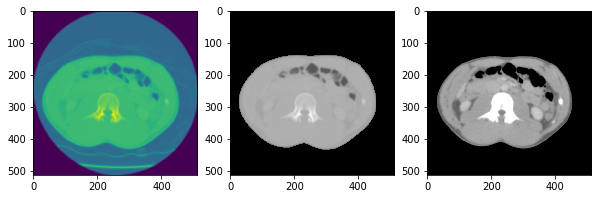

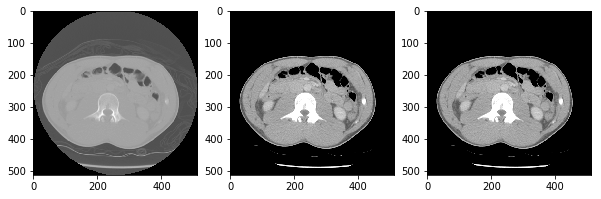

In [29]:
run_diagnostics(test_l3s,ind=40) #9

In [101]:
test = test_l3s[9].pixel_data

In [102]:
test.shape

(512, 512)

In [113]:
test2 = smooth_img(test)
np.min(test)

Before noise:  31.08467538944392  After noise:  0.25766625203086835


-3280

In [105]:
np.min(test)

-3280

In [107]:
ind = np.unravel_index(np.argmin(test, axis=None), test.shape)
ind

(227, 458)

In [108]:
test[227,458]

-3280

In [109]:
tt = test_l3s[9]

In [110]:
dir(tt)

['__attrs_attrs__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'as_csv_row',
 'axial_series',
 'free_pixel_data',
 'height_of_sagittal_image',
 'number_of_axial_dicoms',
 'pixel_data',
 'predicted_y_in_px',
 'prediction_index',
 'prediction_result',
 'sagittal_series',
 'subject_id']

In [111]:
tt.prediction_result

MinimalResult(prediction=MinimalPrediction(predicted_y_in_px=103.8))

In [112]:
tt.prediction_index

(268,
 L3AxialSliceMetadata(sagittal_start_z_pos=-1023.50751, first_axial_pos=-1024.5, last_axial_pos=-1285.0, l3_axial_image_index=268, axial_image_count=666, predicted_z_position=-1127.30751, l3_axial_image_dcm_path=PosixPath('/tf/data/Z1939610/Z1939610-SE-20-Bone_Stnd_Bone_Sharp_Bone_0.5/1.2.840.113654.2.70.1.245770781970033063742681114790294133997.dcm')))